In [3]:
# Importing the libraries
import pandas as pd
import spacy
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [4]:
# Load the dataset

data = pd.read_csv(r"C:\Users\nuzha\Downloads\archive (5)\instagram.csv")
df = data.iloc[:1000]
df.head()

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",2,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,5,2023-07-25 03:24:58
3,"I love this app.. but as of late, I have been ...",2,2023-07-09 04:49:57
4,Used to be a great app but there are so many m...,3,2023-07-17 16:47:04


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  1000 non-null   object
 1   rating              1000 non-null   int64 
 2   review_date         1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


## Cleaning the texts 

In [6]:


# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

# Define text cleaning functions

def clean_text(text):
    """Clean the text by removing citations, extra whitespaces, and converting to lowercase."""
    text = re.sub(r'\[\d+\]', '', text)  # Remove citations
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces and strip
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from the text."""
    PUNCT_TO_REMOVE = """!"'()*+,-/:;<=>?[\]_`{|}~@#$^%&\n\t"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def lemmatize_and_filter(text):
    """Lemmatize and filter out non-English words using spaCy."""
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.lang_ == 'en'])

def nltk_clean_and_tokenize(text):
    """Tokenize the text and clean it further."""
    sentences = sent_tokenize(text)
    return [' '.join(word_tokenize(sent)) for sent in sentences]

def process_text(review):
    """Process the text through all cleaning steps and calculate word count."""
    clean_rv = clean_text(review)
    clean_rv = remove_punctuation(clean_rv)
    clean_rv = lemmatize_and_filter(clean_rv)
    clean_rv = ' '.join([word for word in clean_rv.split() if word not in STOP_WORDS])
    cleaned_review = nltk_clean_and_tokenize(clean_rv)
    return cleaned_review

def count_word(review):
    """Count the number of words in the review."""
    return sum(len(word_tokenize(sentence)) for sentence in review)

# Apply the text processing and word count functions


df['clean_review'] = df['review_description'].apply(process_text)
df['word_count_clean'] = df['clean_review'].apply(count_word)

df['clean_review'] = df['clean_review'].apply(lambda x: ' '.join(x))


df.sample(10)


C:\Users\nuzha\AppData\Local\Temp\ipykernel_31572\2511888699.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_review'] = df['review_description'].apply(process_text)
C:\Users\nuzha\AppData\Local\Temp\ipykernel_31572\2511888699.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count_clean'] = df['clean_review'].apply(count_word)
C:\Users\nuzha\AppData\Local\Temp\ipykernel_31572\2511888699.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,review_description,rating,review_date,clean_review,word_count_clean
227,Instagram's usability is continuously degradin...,1,2023-05-27 19:59:41,instagram usability continuously degrading . I...,47
801,My feed is cluttered with irrelevant ads and s...,1,2023-06-06 19:58:10,feed cluttered irrelevant ad suggest post I m ...,52
986,This apps format has just gotten worse and wor...,2,2023-06-18 15:04:33,app format bad bad past 2 month . I immediatel...,44
328,"From the past few days, I'm trying to change t...",2,2023-07-09 03:10:41,past day I m try change filter specific chat f...,36
132,App has two bugs but not sure if one is a bug ...,1,2023-05-13 03:04:01,app bug sure bug new restriction . bug post mu...,29
57,"In the edit, it be nice to have a borderline f...",3,2023-07-04 22:31:38,edit nice borderline frame 🖼 ️ picture straigh...,30
246,"The app is full of bugs it's tiring, themes no...",1,2023-07-11 17:52:59,app bug tire theme account late update second ...,29
619,It's Buggy. 1. Themes aren't showing properly ...,2,2023-07-07 17:48:11,buggy . 1 . theme properly 2 . message send 3 ...,41
913,"Instagram has been glichy for a long time, but...",2,2023-07-15 04:56:15,instagram glichy long time new glitch infuriat...,52
547,The app keeps crashing all the time from past ...,1,2023-07-09 03:22:12,app crash time past 3 day . I account . I use ...,30


# Predicting App Review Ratings

### Feature Engineering

In [7]:

tfidf_vector = TfidfVectorizer()
X_tfidf = tfidf_vector.fit_transform(df['clean_review'])

### Model Development

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [9]:


# Defining the  parameter grids for each model
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Define models
models = {
    'Ridge Regression': (Ridge(), param_grid_ridge),
    'Lasso Regression': (Lasso(), param_grid_lasso),
    'Random Forest': (RandomForestRegressor(random_state=42), param_grid_rf),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), param_grid_gb)
}

# Function to perform grid search and evaluate model
def perform_grid_search(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Best Score (neg MSE): {-grid_search.best_score_}")
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}")
    print("-------------------------------------------------")
    
    return best_model

# Splitinging data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['rating'], test_size=0.2, random_state=42)

# Perform grid search for each model
best_models = {}
for model_name, (model, param_grid) in models.items():
    best_model = perform_grid_search(model, param_grid, X_train, y_train, X_test, y_test, model_name)
    best_models[model_name] = best_model


Ridge Regression - Best Parameters: {'alpha': 1.0}
Ridge Regression - Best Score (neg MSE): 0.9496261622941002
Ridge Regression - RMSE: 0.9746168816608213, MAE: 0.7938201712974566
-------------------------------------------------
Lasso Regression - Best Parameters: {'alpha': 0.1}
Lasso Regression - Best Score (neg MSE): 1.2200634765625
Lasso Regression - RMSE: 1.06948585778401, MAE: 0.8933
-------------------------------------------------
Random Forest - Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Random Forest - Best Score (neg MSE): 1.0152787315787295
Random Forest - RMSE: 1.0219022931978285, MAE: 0.8210668443490536
-------------------------------------------------
Gradient Boosting - Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting - Best Score (neg MSE): 1.0178587900819565
Gradient Boosting - RMSE: 1.0098423203127733, MAE: 0.8294620248699929
-------------------------------------------------


**Ridge Regression outperforms the other models with the lowest RMSE and MAE, suggesting it is the most accurate for  data.**

# Anomaly Detection in Ratings

In [12]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge()

grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {-grid_search.best_score_}")

best_ridge_model = grid_search.best_estimator_
y_pred_best_ridge = best_ridge_model.predict(X_test)
df['predicted_rating'] = best_ridge_model.predict(X_tfidf)

df['rating_difference'] = np.abs(df['rating'] - df['predicted_rating'])

threshold = 1

df['anomaly'] = df['rating_difference'] > threshold

anomalies = df[df['anomaly']]
anomalies.info()

Best Parameters: {'alpha': 1.0}
Best Score: 0.9496261622941002
<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 2 to 995
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_description  125 non-null    object 
 1   rating              125 non-null    int64  
 2   review_date         125 non-null    object 
 3   clean_review        125 non-null    object 
 4   word_count_clean    125 non-null    int64  
 5   predicted_rating    125 non-null    float64
 6   rating_difference   125 non-null    float64
 7   anomaly             125 non-null    bool   
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 7.9+ KB


C:\Users\nuzha\AppData\Local\Temp\ipykernel_31572\878858759.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_rating'] = best_ridge_model.predict(X_tfidf)
C:\Users\nuzha\AppData\Local\Temp\ipykernel_31572\878858759.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_difference'] = np.abs(df['rating'] - df['predicted_rating'])
C:\Users\nuzha\AppData\Local\Temp\ipykernel_31572\878858759.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

### Highlighting Anomalies

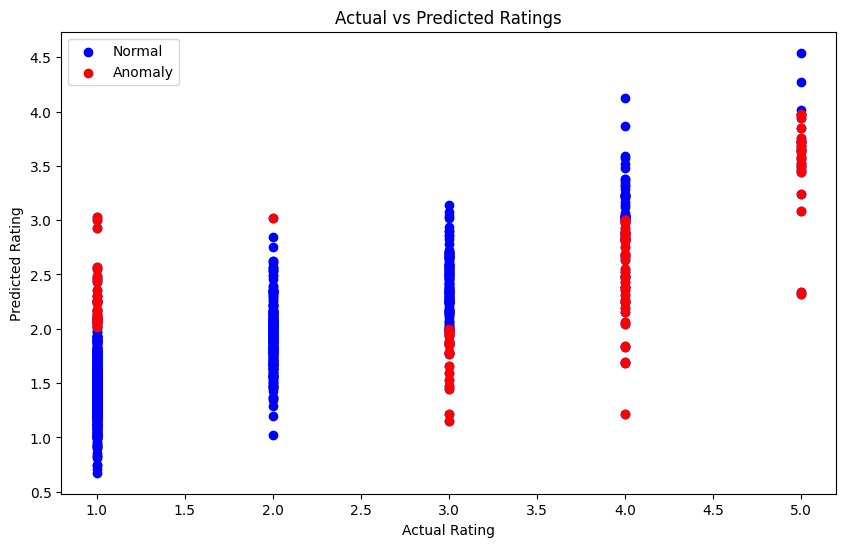

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df['rating'], df['predicted_rating'], c='blue', label='Normal')
plt.scatter(anomalies['rating'], anomalies['predicted_rating'], c='red', label='Anomaly')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.show()



In [ ]:
def export_data_to_excel(df, file_path):
     """Export the DataFrame to an Excel file."""
     with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
         df.to_excel(writer, index=False)

# Dataset exporting 

export_data_to_excel(df, 'review_processed_data.xlsx')